# diagnosis_regression.ipynb

This notebook uses de novo variant data from a large cohort of individuals with cardiac defects$^{1}$ to relate diagnosis categories to risk of having a de novo variant in a GATA4-TBX5 interactome gene.

$^{1}$Jin, Sheng Chih, Jason Homsy, Samir Zaidi, Qiongshi Lu, Sarah Morton, Steven R. DePalma, Xue Zeng, et al. 2017. “Contribution of Rare Inherited and de Novo Variants in 2,871 Congenital Heart Disease Probands.” Nature Genetics 49 (11): 1593–1601.

In [1]:
diagnoses = read.csv('../data/variants/diagnoses.csv', stringsAsFactors=FALSE)

categories = read.csv('../data/databases/diagnostic_categories.csv',header=TRUE, 
                      stringsAsFactors=FALSE)
categories = categories[,c(1:2)]
names(categories) = c("DIAGNOSES","CATEGORY")

In [2]:
# Match each proband to their individual diagnoses
diag_list = c()
diag_df = data.frame(matrix(ncol=2, nrow=0))
colnames(diag_df) = c("Blinded.ID", "DIAGNOSES")

for (i in 1:nrow(diagnoses)){
  
  my_diags = c()
  my_id = diagnoses[i,'Blinded.ID']
  
  if( diagnoses[i,'Cohort'] == "PCGC"){
    diags = strsplit(diagnoses[i,'Cardiac.Diagnoses']," \\| ")
    for(j in diags){
      diag_list = c(diag_list, trimws(j))
      my_diags = c(my_diags,trimws(j))
    }
  } else if(diagnoses[i,'Cohort'] == 'PHN' & grepl(';',diagnoses[i, 'Cardiac.Diagnoses'])){
    diags = strsplit(diagnoses[i,'Cardiac.Diagnoses'],";")
    for(j in diags){
      diag_list = c(diag_list, toupper(trimws(j)))
      my_diags = c(my_diags, toupper(trimws(j)))
    }
  } else{
    diags = strsplit(diagnoses[i,'Cardiac.Diagnoses'],", ")
    for(j in diags){
      diag_list = c(diag_list, toupper(trimws(j)))
      my_diags = c(my_diags, toupper(trimws(j)))
    }
  }
  
  df = data.frame(Blinded.ID = rep(my_id, length(my_diags)), DIAGNOSES = my_diags)
  diag_df = rbind(diag_df, df)
  
}

head(diag_df)

Blinded.ID,DIAGNOSES
1-01074,AORTIC STENOSIS AND REGURGITATION (MIXED AORTIC VALVE DISEASE)
1-01074,BICOMMISSURAL AORTIC VALVE
1-01074,SCREENER DIAGNOSIS: LEFT-SIDED OBSTRUCTIVE LESION
1-01074,AORTIC STENOSIS AND REGURGITATION
1-03156,SCREENER DIAGNOSIS: CONOTRUNCAL ABNORMALITY
1-03156,TETRALOGY OF FALLOT WITH PULMONARY ATRESIA AND MULTIPLE AORTOPULMONARY COLLATERALS


In [3]:
# Merge with refined categories
diag_df$Category = categories$CATEGORY[match(diag_df$DIAGNOSES, categories$DIAGNOSES)]
diag_df = diag_df[complete.cases(diag_df), ]
head(diag_df)

,Blinded.ID,DIAGNOSES,Category
4,1-01074,AORTIC STENOSIS AND REGURGITATION,Semilunar valvular
7,1-03156,TETRALOGY OF FALLOT,Conotruncal (septation and spiraling)
13,1-05629,AORTIC REGURGITATION,Semilunar valvular
16,1-06450,TETRALOGY OF FALLOT,Conotruncal (septation and spiraling)
20,1-07571,TETRALOGY OF FALLOT,Conotruncal (septation and spiraling)
24,1-09580,TETRALOGY OF FALLOT,Conotruncal (septation and spiraling)


In [4]:
# Find the number of de novo mutations each proband has in interactome genes
gene_table = read.table("../intermediate/interactome_lists/GATA4-TBX5_genes.txt", 
                        stringsAsFactors = FALSE)
interactome = gene_table$V1

dnv_cases = read.csv('../data/variants/DNV_cases_v10v11.csv', stringsAsFactors = FALSE)
dnv_ctrls = read.csv('../data/variants/DNV_ctrls.csv', stringsAsFactors = FALSE)

dnv_cases = dnv_cases[which(dnv_cases$Variant.Class != 'syn'),]
dnv_ctrls = dnv_ctrls[which(dnv_ctrls$Variant.Class != 'syn'),]

dnv_cases$interactome <- ifelse(dnv_cases$Gene %in% interactome, 1, 0)
dnv_ctrls$interactome <- ifelse(dnv_ctrls$Gene %in% interactome, 1, 0)

case_var_count = aggregate(dnv_cases$interactome, by=list(Category=dnv_cases$Blinded.ID), 
                           FUN=sum)
ctrl_var_count = aggregate(dnv_ctrls$interactome, by=list(Category=dnv_ctrls$Blinded.ID), 
                           FUN=sum)

var_count = rbind(case_var_count, ctrl_var_count)
names(var_count) = c("Blinded.ID","interactome_dnv_count")
head(var_count)

Blinded.ID,interactome_dnv_count
1-00005,0
1-00009,0
1-00018,0
1-00030,0
1-00045,0
1-00057,0


In [5]:
# Append dummy variable columns based on diagnoses of each blinded ID
variable_list = unique(diag_df$Category)

variable_test = head(variable_list)
for(diagnosis in variable_list){
  var_count[,diagnosis] = 0
  
  focal_df = diag_df[which(diag_df$Category == diagnosis),]
  var_count[which(var_count$Blinded.ID %in% focal_df$Blinded.ID), diagnosis] <- 1
  
}

# Remove Syndromic and Arrythmia categories
var_count$`Arrhythmia/conduction defects` <- NULL
var_count$Syndromic <- NULL

head(var_count)

Blinded.ID,interactome_dnv_count,Semilunar valvular,Conotruncal (septation and spiraling),Single Ventricle Defect,Septation,AV valvular,Arterial vascular anomaly,Coronary anomaly,Situs (Van Praag/Anderson),Venous vascular anomaly,AV Canal,L/R Asymmetry,Misc,Cardiomyopathy
1-00005,0,0,1,0,1,0,1,0,0,0,0,0,0,0
1-00009,0,1,1,1,0,0,0,0,1,0,0,0,0,0
1-00018,0,1,0,1,1,1,1,0,0,1,0,0,0,0
1-00030,0,1,0,1,1,1,1,0,0,0,0,0,0,0
1-00045,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1-00057,0,0,1,0,1,0,0,0,0,0,0,0,0,0


In [6]:
# Order as desired and fit to a poisson model

df = var_count[,c('Blinded.ID','interactome_dnv_count','Arterial vascular anomaly',
                  'Septation','Cardiomyopathy','AV Canal', 'Coronary anomaly',
                  'Conotruncal (septation and spiraling)','L/R Asymmetry',
                  'Venous vascular anomaly','Semilunar valvular','AV valvular',
                  'Single Ventricle Defect','Misc', 'Situs (Van Praag/Anderson)')]
X = df[2:ncol(df)]
row.names(X) = df$Blinded.ID
poisson.model <- glm(interactome_dnv_count~., data=X, family=poisson(link="log"))
summary(poisson.model)

result_df <- data.frame(summary(poisson.model)$coefficients)
result_df[which(result_df$Pr...z.. < 0.1),]


Call:
glm(formula = interactome_dnv_count ~ ., family = poisson(link = "log"), 
    data = X)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5987  -0.2925  -0.2314  -0.2170   3.7013  

Coefficients:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -3.74911    0.17084 -21.945  < 2e-16
`Arterial vascular anomaly`              0.62137    0.23129   2.686  0.00722
Septation                                0.46844    0.22351   2.096  0.03609
Cardiomyopathy                           0.67242    0.46798   1.437  0.15076
`AV Canal`                               0.51077    0.42633   1.198  0.23089
`Coronary anomaly`                       0.51512    0.40519   1.271  0.20361
`Conotruncal (septation and spiraling)`  0.12891    0.22557   0.572  0.56766
`L/R Asymmetry`                         -0.22418    0.62020  -0.361  0.71775
`Venous vascular anomaly`               -0.15441    0.36008  -0.429  0.66806
`Semil

,Estimate,Std..Error,z.value,Pr...z..
(Intercept),-3.7491090,0.1708412,-21.944990,9.668964e-107
`Arterial vascular anomaly`,0.6213661,0.2312924,2.686497,7.220567e-03
Septation,0.4684429,0.2235084,2.095863,3.609438e-02


In [7]:
# Install packages that give conda environments grief

if (! 'jtools' %in% installed.packages()[,'Package']){
    install.packages('jtools')
}

if (! 'ggstance' %in% installed.packages()[,'Package']){
    install.packages('ggstance')
}

In [8]:
# Visualization
library(jtools)
library(ggplot2)
pdf("../manuscript/figures/diagnostic_category_regression.pdf")
p <- plot_summs(poisson.model, scale = TRUE, exp=TRUE)
p + labs(x="Relative Risk (95% Confidence)")

dev.off()

Registered S3 methods overwritten by 'broom':
  method            from  
  tidy.glht         jtools
  tidy.summary.glht jtools
Loading required namespace: broom.mixed


png 
  2

Loading required namespace: broom.mixed


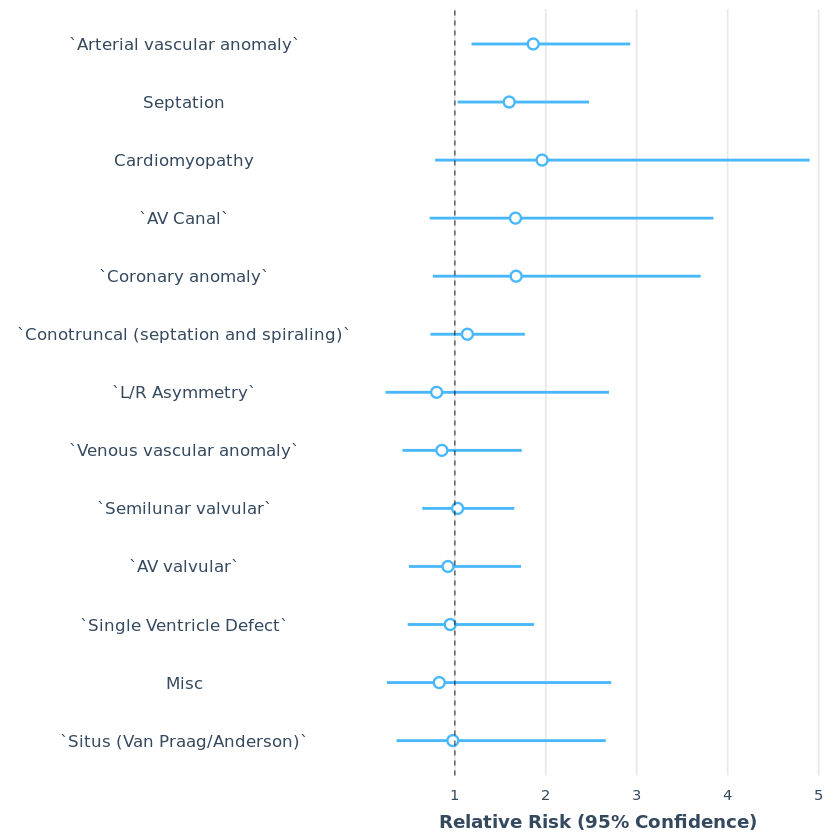

In [9]:
p <- plot_summs(poisson.model, scale = TRUE, exp=TRUE)
p + labs(x="Relative Risk (95% Confidence)")

### Save out data: how many probands per diagnosis? How many interactome mutations?

In [10]:
n_probands = colSums(var_count[,c(3:ncol(var_count))])
n_probands

Semilunar valvular Conotruncal (septation and spiraling) 
                                  782                                   912 
              Single Ventricle Defect                             Septation 
                                  370                                   893 
                          AV valvular             Arterial vascular anomaly 
                                  436                                   525 
                     Coronary anomaly            Situs (Van Praag/Anderson) 
                                  103                                   110 
              Venous vascular anomaly                              AV Canal 
                                  266                                   114 
                        L/R Asymmetry                                  Misc 
                                   96                                    81 
                       Cardiomyopathy 
                                   58

In [11]:
get_n_mutations <- function(diagnosis, vdf){
    
    dat = vdf[which(vdf[,diagnosis]==1),]
    count = sum(dat$interactome_dnv_count)
    
    return(count)
}

In [12]:
result_df$Number.of.Probands = 'NA'
result_df$Total.Interactome.Mutations = 'NA'

for (i in c(2:nrow(result_df))){
    diagnosis = gsub('`','',row.names(result_df)[i])
    result_df[i,'Number.of.Probands'] = n_probands[diagnosis]
    result_df[i,'Total.Interactome.Mutations'] = get_n_mutations(diagnosis,var_count)
}
result_df

,Estimate,Std..Error,z.value,Pr...z..,Number.of.Probands,Total.Interactome.Mutations
(Intercept),-3.74910905,0.1708412,-21.94498976,9.668964e-107,NA,NA
`Arterial vascular anomaly`,0.62136613,0.2312924,2.68649668,7.220567e-03,525,34
Septation,0.46844291,0.2235084,2.09586264,3.609438e-02,893,48
Cardiomyopathy,0.67242341,0.4679790,1.43686656,1.507559e-01,58,5
`AV Canal`,0.51077111,0.4263315,1.19806084,2.308933e-01,114,7
`Coronary anomaly`,0.51512129,0.4051851,1.27132325,2.036137e-01,103,7
`Conotruncal (septation and spiraling)`,0.12891421,0.2255684,0.57150841,5.676551e-01,912,42
`L/R Asymmetry`,-0.22418133,0.6201984,-0.36146714,7.177503e-01,96,4
`Venous vascular anomaly`,-0.15440975,0.3600837,-0.42881628,6.680569e-01,266,11
`Semilunar valvular`,0.02948484,0.2414900,0.12209549,9.028234e-01,782,36


In [13]:
result_df$Relative.Risk = exp(result_df$Estimate)
result_df

,Estimate,Std..Error,z.value,Pr...z..,Number.of.Probands,Total.Interactome.Mutations,Relative.Risk
(Intercept),-3.74910905,0.1708412,-21.94498976,9.668964e-107,NA,NA,0.02353871
`Arterial vascular anomaly`,0.62136613,0.2312924,2.68649668,7.220567e-03,525,34,1.86146932
Septation,0.46844291,0.2235084,2.09586264,3.609438e-02,893,48,1.59750480
Cardiomyopathy,0.67242341,0.4679790,1.43686656,1.507559e-01,58,5,1.95897898
`AV Canal`,0.51077111,0.4263315,1.19806084,2.308933e-01,114,7,1.66657581
`Coronary anomaly`,0.51512129,0.4051851,1.27132325,2.036137e-01,103,7,1.67384151
`Conotruncal (septation and spiraling)`,0.12891421,0.2255684,0.57150841,5.676551e-01,912,42,1.13759253
`L/R Asymmetry`,-0.22418133,0.6201984,-0.36146714,7.177503e-01,96,4,0.79917020
`Venous vascular anomaly`,-0.15440975,0.3600837,-0.42881628,6.680569e-01,266,11,0.85692082
`Semilunar valvular`,0.02948484,0.2414900,0.12209549,9.028234e-01,782,36,1.02992383


In [14]:
names(result_df) <- c('Regression.Coefficient', 'Std.Error','z.score','p.value',
                      'N.probands.with.diagnosis','N.interactome.mutations.in.probands',
                      'Relative.Risk')
row.names(result_df) <- gsub('`','',row.names(result_df))

In [15]:
result_df = result_df[,c('Regression.Coefficient','Relative.Risk','Std.Error','z.score',
                         'p.value','N.probands.with.diagnosis',
                         'N.interactome.mutations.in.probands')]

write.csv(result_df, '../manuscript/tables/diagnostic_regression.csv', 
          quote=FALSE)